In [111]:
import numpy as np
import pandas as pd
import mnist
import random
import cv2
import scipy.misc
from PIL import Image
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

In [2]:
import tensorflow as tf
import keras
from keras import layers
from keras import optimizers
from keras.layers import Input, Lambda, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, AlphaDropout
from keras.layers import Conv2D, SpatialDropout2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.utils import plot_model
import keras.backend as K
from keras.applications import resnet, resnet_v2, vgg16, vgg19
from keras.utils import to_categorical
import efficientnet.keras as eff

Using TensorFlow backend.


In [3]:
test_image = mnist.test_images()
test_gt = mnist.test_labels()
test_gt = to_categorical(test_gt)

In [4]:
# prepare data
tests = mnist.test_images()
x_test_norm = np.asarray([cv2.resize(a, (56, 56), interpolation = cv2.INTER_LINEAR) for a in tests]).reshape(10000, 56, 56, 1)
y_test_norm = to_categorical(mnist.test_labels())

In [5]:
def refresh():
    global test_img
    test_img = copy.deepcopy(test_image)
    global b_to_w_ray
    b_to_w_ray = copy.deepcopy(test_image)
    global rand_ray
    rand_ray = copy.deepcopy(test_image)
    global w_to_b_ray 
    w_to_b_ray = copy.deepcopy(test_image)
    global w_to_bline_ray
    w_to_bline_ray = copy.deepcopy(test_image)
    global placehold_img
    placehold_img = copy.deepcopy(test_image)

In [6]:
refresh()

In [7]:
def showimages(modified_imgs):
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(1, 2),
                     axes_pad=0.1)
    normal = [cv2.resize(aa, dsize=(56, 56), interpolation=cv2.INTER_AREA) for aa in test_image][0:1]
    altered = modified_imgs[0:1]
    result = [None]*(len(normal)+len(altered))
    result[::2] = normal
    result[1::2] = altered
    for ax, im in zip(grid, result):
        ax.imshow(im, cmap='gray')

In [8]:
# outline version
# rand k pixels white to black attack then resize 

def outline(k, test, model, new, show_img):
    global w_to_bline_ray
    if new == True:
        w_to_bline_ray = copy.deepcopy(test_image)
    for count in range(k):
        i = 0
        while i < len(test_img):
            done = False
            while done == False:
                a = random.randrange(27)
                b = random.randrange(27)
                if test_img[i, a, b] >= 200:
                    w_to_bline_ray[i, a, b] = (255 - (test_img[i, a, b]))/4
                    done = True
                    break
            i += 1
    
    resized_WtoB_line = np.asarray([cv2.resize(a, dsize=(56, 56), interpolation=cv2.INTER_AREA) for a in w_to_bline_ray])
    if show_img == True:
        showimages(resized_WtoB_line)
    if test == True:
        result = model.evaluate(resized_WtoB_line.reshape(10000, 56, 56, 1), test_gt, verbose = 0)
#         print(result)
        return result

In [9]:
# rand k pixels white to black attack then resize 

def randomInvert(k, test, model, new, show_img):
    global rand_ray
    if new == True:
        rand_ray = copy.deepcopy(test_image)
    for count in range(k):
        i = 0
        while i < len(test_img):
            done = False 
            while done == False:
                a = random.randrange(27)
                b = random.randrange(27)
                if test_img[i, a, b] >= 0 and test_img[i, a, b] <= 127:
                    rand_ray[i, a, b] = int(255 - test_img[i, a, b]/1.25)
                    done = True
                    break
                else:
                    rand_ray[i, a, b] = int((255 - test_img[i, a, b])/1.25)
                    done = True
                    break
            i += 1
    
    resized_rand = np.asarray([cv2.resize(a, dsize=(56, 56), interpolation=cv2.INTER_AREA) for a in rand_ray])
    if show_img == True:
        showimages(resized_rand)
    if test == True:
        result = model.evaluate(resized_rand.reshape(10000, 56, 56, 1), test_gt, verbose = 0)
#         print(result)
        return result

In [10]:
# rand k pixels white to black attack then resize 
def whiteToBlack(k, test, model, new, show_img):
    global w_to_b_ray
    if new == True:
        w_to_b_ray = copy.deepcopy(test_image)
    for count in range(k):
        i = 0
        while i < len(test_img):
            done = False
            while done == False:
                a = random.randrange(27)
                b = random.randrange(27)
                if test_img[i, a, b] >= 1:
                    w_to_b_ray[i, a, b] = (255 - (test_img[i, a, b]))/4
                    done = True
                    break
            i += 1
    
    resized_WtoB = np.asarray([cv2.resize(a, dsize=(56, 56), interpolation=cv2.INTER_AREA) for a in w_to_b_ray])
    if show_img == True:
        showimages(resized_WtoB)
    if test == True:
        result = model.evaluate(resized_WtoB.reshape(10000, 56, 56, 1), test_gt, verbose = 0)
#         print(result)
        return result

In [11]:
# rand k pixels black to white attack then resize

def blackToWhite(k, test, model, new, show_img):
    global b_to_w_ray
    if new == True:
        b_to_w_ray = copy.deepcopy(test_image)
    for count in range(k):
        i = 0
        while i < len(test_img):
            done = False
            while done == False:
                a = random.randrange(27)
                b = random.randrange(27)
                if test_img[i, a, b] <= 99:
                    b_to_w_ray[i, a, b] = 255 - (test_img[i, a, b])/4
                    done = True
                    break
            i += 1

    resized_BtoW = np.asarray([cv2.resize(a, dsize=(56, 56), interpolation=cv2.INTER_AREA) for a in b_to_w_ray])
    if show_img == True:
        showimages(resized_BtoW)
    if test == True:
        result = model.evaluate(resized_BtoW.reshape(10000, 56, 56, 1), test_gt, verbose = 0)
#         print(result)
        return result

In [12]:
# rand k edge pixels to white attack then resize
# excludes attacking one outlier image index 9051

def check_horiz(k, a1, b):
    check = 0
    if test_img[k, a1, b] > 99 and test_img[k, a1+1, b] <= 99:
        check = 1
    elif test_img[k, a1, b] <= 99 and test_img[k, a1+1, b] > 99:
        check = -1
    elif test_img[k, a1, b] > 99 and test_img[k, a1-1, b] <= 99:
        check = 1
    elif test_img[k, a1, b] <= 99 and test_img[k, a1-1, b] > 99:
        check = -1
    return check
    
def check_vert(k, a, b1):
    check = 0
    if test_img[k, a, b1] > 99 and test_img[k, a, b1+1] <= 99:
        check = 1
    elif test_img[k, a, b1] <= 99 and test_img[k, a, b1+1] > 99:
        check = -1
    elif test_img[k, a, b1] > 99 and test_img[k, a, b1-1] <= 99:
        check = 1
    elif test_img[k, a, b1] <= 99 and test_img[k, a, b1-1] > 99:
        check = -1
    return check

def check_diag(k, a1, b1):
    check = 0
    if test_img[k, a1, b1] > 99 and test_img[k, a1+1, b1+1] <= 99:
        check = 1
    elif test_img[k, a1, b1] <= 99 and test_img[k, a1+1, b1+1] > 99:
        check = -1
    elif test_img[k, a1, b1] > 99 and test_img[k, a1+1, b1-1] <= 99:
        check = 1
    elif test_img[k, a1, b1] <= 99 and test_img[k, a1+1, b1-1] > 99:
        check = -1
    elif test_img[k, a1, b1] > 99 and test_img[k, a1-1, b1-1] <= 99:
        check = 1
    elif test_img[k, a1, b1] <= 99 and test_img[k, a1-1, b1-1] > 99:
        check = -1
    elif test_img[k, a1, b1] > 99 and test_img[k, a1-1, b1+1] <= 99:
        check = 1
    elif test_img[k, a1, b1] <= 99 and test_img[k, a1-1, b1+1] > 99:
        check = -1
        
    return check

def edgeToAlter(k, test, model, new, show_img):
    global placehold_img
    if new == True:
        placehold_img = copy.deepcopy(test_image)
    for count in range(k):
        i = 0
        while i < len(test_img):
            if i == 9051:
                i = 9052
            done = False
            cc = 0
            while done == False:
                if cc > 5000:
                    i = 10000
                a = random.randrange(27)
                b = random.randrange(27)
                if check_vert(i, a, b) == -1 or check_horiz(i, a, b) == -1: 
                    placehold_img[i, a, b] = 255
                    done = True
                    break

                elif check_diag(i, a, b) == -1:
                    placehold_img[i, a, b] = 255
                    done = True
                    break

                elif check_vert(i, a, b) == 1 or check_horiz(i, a, b) == 1:
                    placehold_img[i, a, b] = 0
                    done = True
                    break

                elif check_diag(i, a, b) == 1:
                    placehold_img[i, a, b] = 0
                    done = True
                    break
            i += 1
            
    resized_GtoA = np.asarray([cv2.resize(a, dsize=(56, 56), interpolation=cv2.INTER_AREA) for a in placehold_img]).reshape(10000, 56, 56)
    if show_img == True:
        showimages(resized_GtoA)
    if test == True:
        result = model.evaluate(resized_GtoA.reshape(10000, 56, 56, 1), test_gt, verbose = 0)
#         print(result)
        return result

In [13]:
resnet = load_model('models/resnet_99.h5')
resnetv2 = load_model('models/resnetv2_99.h5')
resnet101 = load_model('models/resnet101_991.h5')
resnet152 = load_model('models/resnet152_96.h5')
VGG19 = load_model('models/VGG19_9934.h5')
FCN = load_model('models/FCN.h5')
efficientnet = load_model('models/efficientnetb1_986.h5')

In [ ]:
resnet18 = 

In [63]:
accs = []
resnet_accs = []
resnetv2_accs = []
resnet101_accs = []
resnet18_accs = []
resnet34_accs = []
VGG19_accs = []
FCN_accs = []
efficientnet_accs = []
def evaluateModels(attack, end = 1, skip = 1, models = ''):
    count = int(end/skip)
    global resnet34_accs, resnet_accs, resnetv2_accs, resnet101_accs, resnet18_accs, VGG19_accs, FCN_accs, efficientnet_accs, accs, attackcounts
    attackcounts = [(c)*skip for c in range(count+1)]
    print(attackcounts)
    if models == 'all':
        for i in range(count):
#             resnet_accs.append(attack(skip, test = True, model = resnet, new = False, show_img = False)[1]*100)
#             resnetv2_accs.append(attack(0, test = True, model = resnetv2, new = False, show_img = False)[1]*100)
#             resnet101_accs.append(attack(0, test = True, model = resnet101, new = False, show_img = False)[1]*100)
            resnet18_accs.append(attack(skip, test = True, model = resnet18, new = False, show_img = False)[1]*100)
            resnet34_accs.append(attack(0, test = True, model = resnet34, new = False, show_img = False)[1]*100)
#             VGG19_accs.append(attack(0, test = True, model = VGG19, new = False, show_img = False)[1]*100)
#             FCN_accs.append(attack(0, test = True, model = FCN, new = False, show_img = False)[1]*100)
#             efficientnet_accs.append(attack(0, test = True, model = efficientnet, new = False, show_img = False)[1]*100)
    else:
        for i in range(count):
            accs.append(attack(skip, test = True, model = models, new = False, show_img = False)[1]*100)

In [64]:
for i in range(1):
    refresh()
    evaluateModels(whiteToBlack, end = 200, skip = 10, models='all')
    print((i*5+1)/20)
    evaluateModels(blackToWhite, end = 200, skip = 10, models='all')
    print((i*5+2)/20)
    evaluateModels(outline, end = 200, skip = 10, models='all')
    print((i*5+3)/20)
    evaluateModels(randomInvert, end = 200, skip = 10, models='all')
    print((i*5+4)/20)
    evaluateModels(edgeToAlter, end = 200, skip = 10, models='all')
    print((i*5+5)/20)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
0.05
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
0.1
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
0.15
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
0.2
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
0.25


In [33]:
resnet34 = load_model('models/resnet34_99.h5')
resnet18 = load_model('models/resnet18_991.h5')

In [59]:
resnet34.evaluate(x_test_norm, y_test_norm)

10000/10000 [==============================] - 4s 374us/step


[0.02852065611924045, 0.9904000163078308]

[0.11326289982609451, 0.9656999707221985]

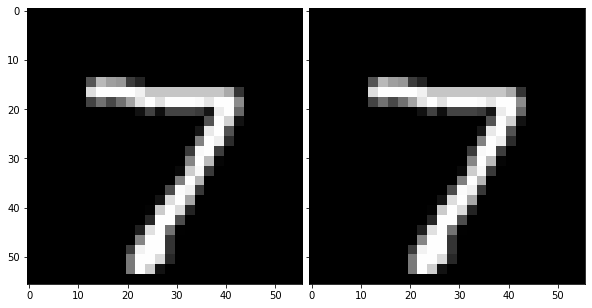

In [58]:
randomInvert(0, test = True, model=resnet34, new = True, show_img = True)

In [18]:
for i in range(1):
    refresh()
    evaluateModels(whiteToBlack, end = 200, skip = 10, models=resnet18)
    print((i*5+1)/20)
    evaluateModels(blackToWhite, end = 200, skip = 10, models=resnet18)
    print((i*5+2)/20)
    evaluateModels(outline, end = 200, skip = 10, models=resnet18)
    print((i*5+3)/20)
    evaluateModels(randomInvert, end = 200, skip = 10, models=resnet18)
    print((i*5+4)/20)
    evaluateModels(edgeToAlter, end = 200, skip = 10, models=resnet18)
    print((i*5+5)/20)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
0.05
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
0.1
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
0.15
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
0.2
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
0.25


In [65]:
resnet18_accs1 = np.array(resnet18_accs)
resnet34_accs1 = np.array(resnet34_accs)

In [66]:
resnet18_accs11 = np.zeros((5,20))
resnet34_accs11 = np.zeros((5,20))
for i in range(5):
    resnet18_accs11[i] = resnet18_accs1[i*20:(i+1)*20]
    resnet34_accs11[i] = resnet34_accs1[i*20:(i+1)*20]

In [53]:
resnet_accs1 = copy.deepcopy(resnet_accs)
resnetv2_accs1 = copy.deepcopy(resnetv2_accs)
resnet101_accs1 = copy.deepcopy(resnet101_accs)
resnet18_accs1 = copy.deepcopy(resnet18_accs)
VGG19_accs1 = copy.deepcopy(VGG19_accs)
FCN_accs1 = copy.deepcopy(FCN_accs)
efficientnet_accs1 = copy.deepcopy(efficientnet_accs)

In [64]:
resnetaccs = np.array(efficientnet_accs)
resnetaccs1 = np.zeros((5, 20))
resnetaccs2 = np.zeros((5, 20))
resnetaccs3 = np.zeros((5, 20))
resnetaccs4 = np.zeros((5, 20))
efficientnetaccsfinal = np.zeros((5, 20))
for i in range(5):
    resnetaccs1[i] = resnetaccs[i*20:(i+1)*20]
    resnetaccs2[i] = resnetaccs[(i+5)*20:((i+5)+1)*20]
    resnetaccs3[i] = resnetaccs[(i+10)*20:((i+10)+1)*20]
    resnetaccs4[i] = resnetaccs[(i+15)*20:((i+15)+1)*20]
for i in range(5):
    for j in range(20):
        efficientnetaccsfinal[i][j] = (resnetaccs1[i][j] + resnetaccs2[i][j] + resnetaccs3[i][j] + resnetaccs4[i][j])/4

In [51]:
print(resnet34_accs)

[96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707221985, 96.56999707

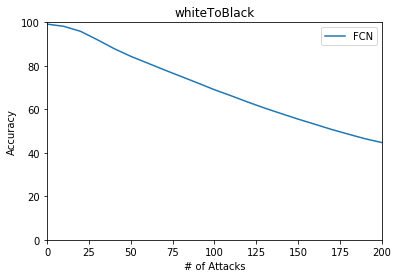

In [58]:
b = np.insert(copy.deepcopy(accs1[0]), 0, 99.1)
plt.plot(attackcounts, np.insert(copy.deepcopy(accs1[0]), 0, 99.1), label = 'Resnet18')
plt.title('whiteToBlack')
plt.axis([0, 200, 0, 100])
plt.ylabel('Accuracy')
plt.xlabel('# of Attacks')
plt.legend()
plt.show()

In [22]:
skip = 10
count = 20
attackcounts = [(c)*skip for c in range(count+1)]

In [ ]:
whiteToBlack()

In [55]:
for a in graph:
    print(len(a))

400
400
400
400
0
400
400


In [54]:
resnets = [resnet_accs, resnet101_accs, resnet152_accs]
graph = [FCN_accs, resnet_accs, resnetv2_accs, resnet101_accs, resnet152_accs, VGG19_accs, efficientnet_accs]

In [21]:
np.savetxt('data/resnet34accs.csv', accs1, delimiter=',', fmt='%s')

In [40]:
resnetaccsfinal = np.genfromtxt('data/resnetaccs.csv', delimiter=',')
resnet101accsfinal = np.genfromtxt('data/resnet101accs.csv', delimiter=',')

In [45]:
resnet18_accs11.shape

(5, 20)

In [30]:
resnets1 = copy.deepcopy(resnets)
graph1 = copy.deepcopy(graph)

In [ ]:
for a in resnets:
    a.insert(0, 99.2)

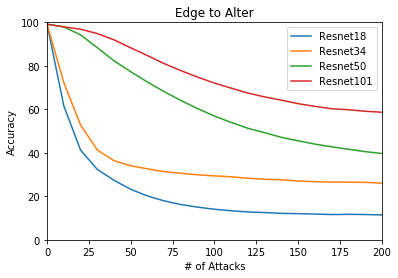

In [73]:
n = 4

plt.plot(attackcounts, np.insert(copy.deepcopy(resnet18_accs11[n]), 0, 99.1), label = 'Resnet18')
plt.plot(attackcounts, np.insert(copy.deepcopy(resnet34_accs11[n]), 0, 99.1), label = 'Resnet34')
plt.plot(attackcounts, np.insert(copy.deepcopy(resnetaccsfinal[n]), 0, 99.2), label = 'Resnet50')
plt.plot(attackcounts, np.insert(copy.deepcopy(resnet101accsfinal[n]), 0, 99.1), label = 'Resnet101')
# plt.plot(attackcounts, resnet152_accs, label = 'Resnet152')
# plt.plot(attackcounts, np.insert(copy.deepcopy(resnetv2accsfinal[n]), 0, 99.3), label = 'Resnet50V2')
# plt.plot(attackcounts, np.insert(copy.deepcopy(VGG19accsfinal[n]), 0, 99.34), label = 'VGG19')
# plt.plot(attackcounts, np.insert(copy.deepcopy(efficientnetaccsfinal[n]), 0, 98.6), label = 'EfficientNet')
# plt.plot(attackcounts, np.insert(copy.deepcopy(FCNaccsfinal[n]), 0, 97), label = 'FCN')
plt.title('Edge to Alter')
plt.axis([0, 200, 0, 100])
plt.ylabel('Accuracy')
plt.xlabel('# of Attacks')
plt.legend()
plt.show()

In [15]:
evaluateModels(whiteToBlack, end = 200, skip = 10, models='all')

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
[0.06261602610524278, 0.9807999730110168]
[0.03241317950596567, 0.9889000058174133]
[0.055135565650463104, 0.9833999872207642]
[1.3525884284824132, 0.8342999815940857]
[0.033446202831001935, 0.9911999702453613]
[0.7108645027186256, 0.948199987411499]
[0.07535707835364155, 0.9761000275611877]
[0.13606478706113995, 0.9563000202178955]
[0.06413170176104177, 0.9793999791145325]
[0.07567956470437348, 0.9745000004768372]
[1.2987337650716304, 0.807200014591217]
[0.04691779745010717, 0.9868000149726868]
[1.3305408388158306, 0.9275000095367432]
[0.1075284947739914, 0.9652000069618225]
[0.26096734066456556, 0.9207000136375427]
[0.12624066723659635, 0.9614999890327454]
[0.11974682586081326, 0.9607999920845032]
[1.3412903281211852, 0.7605999708175659]
[0.06567123221796937, 0.9818000197410583]
[1.9661340134121477, 0.902999997138977]
[0.17469113121014088, 0.9466000199317932]
[0.4188806211292744, 0.87749999

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
[1.1007940278470516, 0.8295999765396118]
[1.0949987849235534, 0.769599974155426]
[1.2737878571987151, 0.7041000127792358]
[1.4443100688934327, 0.6477000117301941]
[1.6317837703704834, 0.5983999967575073]
[1.8413348850250244, 0.5533999800682068]
[2.022973122024536, 0.5163000226020813]
[2.1779973300933837, 0.4846000075340271]
[2.337227925491333, 0.4535999894142151]
[2.4724591796875, 0.42800000309944153]
[2.5916044361114503, 0.4074999988079071]
[2.6921764511108397, 0.39070001244544983]
[2.780931555557251, 0.37529999017715454]
[2.8635406978607176, 0.36329999566078186]
[2.935061922454834, 0.3476000130176544]
[3.01570588722229, 0.3328999876976013]
[3.06406227684021, 0.3224000036716461]
[3.110578666305542, 0.31369999051094055]
[3.1630643836975096, 0.30649998784065247]
[3.2029181118011474, 0.301800012588501]


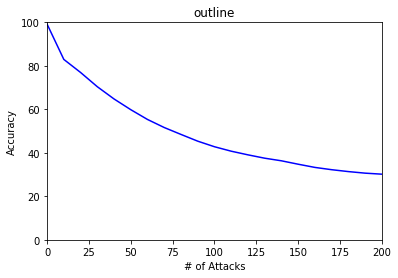

[99.2, 82.95999765396118, 76.9599974155426, 70.41000127792358, 64.77000117301941, 59.83999967575073, 55.33999800682068, 51.63000226020813, 48.46000075340271, 45.35999894142151, 42.80000030994415, 40.74999988079071, 39.07000124454498, 37.529999017715454, 36.329999566078186, 34.76000130176544, 33.28999876976013, 32.24000036716461, 31.369999051094055, 30.649998784065247, 30.180001258850098]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
[1.3750338330090046, 0.8313000202178955]
[1.3039650304555892, 0.8076000213623047]
[1.3330065351963043, 0.7616999745368958]
[1.4087425996780396, 0.715399980545044]
[1.508043268585205, 0.6690999865531921]
[1.6270649307250977, 0.6312999725341797]
[1.7398996662139892, 0.5950999855995178]
[1.8683714740753175, 0.5622000098228455]
[2.0031409301757814, 0.531499981880188]
[2.124831280899048, 0.5059999823570251]
[2.2428817234039307, 0.4796999990940094]


KeyboardInterrupt: 

In [33]:
refresh()
model = load_model('models/resnet152_96.h5')
print(createGraph(outline, end = 200, skip = 10))
print(createGraph(whiteToBlack, end = 200, skip = 10))
print(createGraph(blackToWhite, end = 200, skip = 10))
print(createGraph(randomInvert, end = 200, skip = 10))
print(createGraph(edgeToAlter, end = 200, skip = 10))

In [121]:
whiteToBlack(1, test = False, model='', new = True, show_img = False)

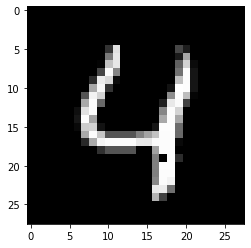

In [119]:
n=4
plt.imshow(w_to_b_ray[n], cmap='gray')

In [113]:
resnet50 = load_model('models/resnet_99.h5')

In [ ]:
c = 2
found = False
while found == False:
    whiteToBlack(c, test = False, model='', new = True, show_img = False)
    for i in range(len(b_to_w_ray)):
        if np.argmax(resnet50.predict(x_test_norm[n].reshape(1, 56, 56, 1))) != np.argmax(resnet50.predict(cv2.resize(w_to_b_ray[n], dsize=(56, 56), interpolation=cv2.INTER_AREA).reshape(1, 56, 56, 1))):
            print(str(i) + ' index')
            found = True
    c += 1
    print(c)

3


In [86]:
print(np.argmax(vgg.predict(x_test_norm[n].reshape(1, 56, 56, 1))))
print(np.argmax(vgg.predict(cv2.resize(w_to_b_ray[n], dsize=(56, 56), interpolation=cv2.INTER_LINEAR).reshape(1, 56, 56, 1))))

1